In [71]:
import pandas as pd
import geopandas as gpd
import numpy as np
from quetzal.model import stepmodel

In [2]:
# Load the model with LoS tables from the last exercise
model_path = '../../model/'
sm = stepmodel.read_json(model_path + 'los_tables')

## Step trip generation
In every zone we need to generate a column `emission` and `attraction`. What kind of trips you count to it largely affects the interpretability of your results. If you use employment characteristics only for attraction, your model will only be applicable to commuting questions, but not for shopping or leisure trips. Moreover, the results of a congestion analysis after the assignment step are worthless because the real network load is higher when you consider all demand segments.

In [3]:
# Lets see what data we have
sm.zones.sample()

,area,emp,emp_dens,id,name,pop,pop_dens,geometry
index,,,,,,,,
zone_24,955473.121308,90955.30831,95194,25,25,13499.879731,14129,"POLYGON ((2.34863 48.87413, 2.34863 48.87356, ..."


<AxesSubplot:>

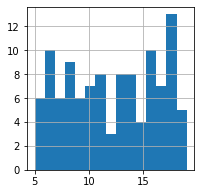

In [4]:
# Let's add the number of shops per zone to add at least this travel purpose
# Use random numbers for the toy model. Normally we would use land use data
# from OpenStreetMap (tutorials available)
# POI = point of interest
sm.zones['POIs'] = np.random.randint(5, 20, len(sm.zones))
# Check the distribution
sm.zones['POIs'].hist(bins=15, figsize=(3,3))

In [5]:
# Start with emission and attraction from commuting purposes
# Assumptions (usually derived from a mobility survey):
employment_rate = 0.7
home_office_rate = 0.1
work_trips_per_day = 1.05 # we set up the model for one average weekday!
sm.zones['emission'] = sm.zones['pop'] * work_trips_per_day * (1-home_office_rate) * employment_rate
sm.zones['attraction'] = sm.zones['emp']

In [6]:
# Now add the shopping purpose (usually derived from a mobility survey)
shopping_trips_per_day = 0.3
attraction_per_POI = sm.zones['pop'].mean() / sm.zones['POIs'].mean() * shopping_trips_per_day
sm.zones['emission'] += sm.zones['pop'] * shopping_trips_per_day
sm.zones['attraction'] += sm.zones['POIs'] * attraction_per_POI

array([[<AxesSubplot:title={'center':'attraction'}>,
        <AxesSubplot:title={'center':'emission'}>]], dtype=object)

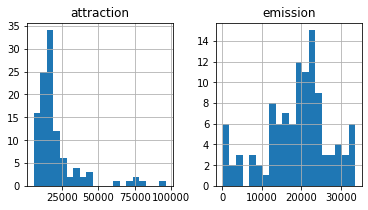

In [7]:
sm.zones[['emission', 'attraction']].hist(bins=20, figsize=(6,3))

In [8]:
# Now we need to introduce our demand segments.
# Car owners and PT captives is a good start.
# Other common demand segments are trip purposes, income groups, age groups.
sm.segments = ['car_owner', 'pt_captive']
car_ownership = 0.4
sm.zones[('car_owner', 'emission')] = sm.zones['emission'] * car_ownership
sm.zones[('pt_captive', 'emission')] = sm.zones['emission'] * (1-car_ownership)
sm.zones[('car_owner', 'attraction')] = sm.zones['attraction'] * car_ownership
sm.zones[('pt_captive', 'attraction')] = sm.zones['attraction'] * (1-car_ownership)

In [9]:
# Cast columns to integer
sm.zones[('car_owner', 'emission')] = sm.zones[('car_owner', 'emission')].astype(int)
sm.zones[('car_owner', 'attraction')] = sm.zones[('car_owner', 'attraction')].astype(int)
sm.zones[('pt_captive', 'emission')] = sm.zones[('pt_captive', 'emission')].astype(int)
sm.zones[('pt_captive', 'attraction')] = sm.zones[('pt_captive', 'attraction')].astype(int)

In [11]:
# Delete the non-segmented columns to prevent errors
del sm.zones['emission']
del sm.zones['attraction']
sm.zones.sample()

,area,emp,emp_dens,id,name,pop,pop_dens,geometry,POIs,"(car_owner, emission)","(pt_captive, emission)","(car_owner, attraction)","(pt_captive, attraction)"
index,,,,,,,,,,,,,
zone_25,447369.027785,11915.226686,26634,26,26,8573.827417,19165,"POLYGON ((2.35666 48.87981, 2.35644 48.87903, ...",6,3297,4946,5929,8893


## Step distribution

Once we have emission and attraction, we want to know the volumes per OD-pair. We can use the `step_distribution` function from quetzal. It uses the doubly constrained distribution (no probabilistic Logit approach), which is an iterative process where emissions and attractions are matched so that, on average, the minimal resistance for the whole system is found. Talking about resistance: an important input parameter is the impedance matrix, giving resistances between every OD-pair. Resistance can be time, but also cost or other utility/disutility quantifications.

Calibration of this step (not performed in this toy model) requires to change emission and attraction values or the impedance matrix

In [12]:
# Now, we need an impedance matrix for car and PT, respectively.
# Use time as resistance value, but distance or cost are thinkable, too
car_imp_matrix = sm.car_los[['origin', 'destination', 'time']].set_index(
    ['origin','destination']).unstack()
# Assign a resistance for staying in the home cell
car_imp_matrix = car_imp_matrix.replace(0, 120)

In [13]:
car_imp_matrix.head(3)

time                                                    \
destination      zone_0      zone_1     zone_10     zone_100     zone_101   
origin                                                                      
zone_0       120.000000  334.703776  601.163489   897.178247  1260.020489   
zone_1       445.151683  120.000000  586.301405   683.663621  1046.505862   
zone_10      478.001079  507.424308  120.000000  1045.643496  1408.485737   

                                                                             \
destination    zone_102     zone_103     zone_104     zone_105     zone_106   
origin                                                                        
zone_0       935.680337  1015.885402   914.687279   959.836876  1132.437181   
zone_1       814.352717   819.764214   718.566090   746.322249  1033.806126   
zone_10      973.005227  1129.823561  1028.625437  1097.703855  1169.762070   

             ...                                                    \
destination  ...     zone_90     zone_91      zone_92      zone_93   
origin       ...                                                     
zone_0       ...  804.348197  835.713635   881.703790   900.773114   
zone_1       ...  606.775692  638.141130   668.189163   687.258487   
zone_10      ...  919.585686  950.951124  1021.240348  1049.238362   

                                                                              \
destination      zone_94      zone_95      zone_96      zone_97      zone_98   
origin                                                                         
zone_0        872.761071   970.067374  1116.278110   910.424400  1066.037371   
zone_1        659.246444   756.552747   907.567002   696.909773   852.522744   
zone_10      1021.226319  1118.532623  1230.216269  1058.889648  1214.502620   

                          
destination      zone_99  
origin                    
zone_0       1061.640692  
zone_1        848.126065  
zone_10      1210.105940  

[3 rows x 110 columns]

In [15]:
# In the PT case we have to take the minimum time per OD pair,
# because we have multiple routes
pt_imp_matrix = sm.pt_los.groupby(
    ['origin', 'destination']).agg({'time': 'min'}).unstack()

In [16]:
pt_imp_matrix = pt_imp_matrix.replace(0, 120)
pt_imp_matrix.head(3)

time                                                    \
destination      zone_0      zone_1     zone_10     zone_100     zone_101   
origin                                                                      
zone_0       120.000000  632.734040  793.003000  1368.179461  1631.266529   
zone_1       632.734040  120.000000  998.356222  1363.212905  1617.326494   
zone_10      879.397214  958.115526  120.000000  1487.801643  1649.388711   

                                                                              \
destination     zone_102     zone_103     zone_104     zone_105     zone_106   
origin                                                                         
zone_0       1325.930128  1506.483586  1470.290586  1351.396818  1311.740497   
zone_1       1320.963572  1501.517029  1465.324030  1335.428909  1306.773941   
zone_10      1477.052310  1687.605768  1651.412768  1532.519000  1462.862679   

             ...                                                      \
destination  ...      zone_90      zone_91      zone_92      zone_93   
origin       ...                                                       
zone_0       ...  1176.718676  1181.487094  1451.370854  1512.014844   
zone_1       ...  1171.752120  1176.520538  1446.404298  1490.375178   
zone_10      ...  1426.340858  1366.609276  1579.588117  1608.137026   

                                                                              \
destination      zone_94      zone_95      zone_96      zone_97      zone_98   
origin                                                                         
zone_0       1323.348664  1175.735586  1421.061398  1384.611167  1668.388708   
zone_1       1309.408629  1170.769030  1416.094842  1370.671133  1654.448673   
zone_10      1341.470846  1248.857768  1602.183580  1402.733349  1686.510890   

                          
destination      zone_99  
origin                    
zone_0       1536.670101  
zone_1       1531.703545  
zone_10      1599.047610  

[3 rows x 110 columns]

In [17]:
# We can perform the quetzal distribution function for all
# our demand segments simultaniously, saving us post-processing.
# Therefore, we need a dictionary with all parameters
distr_params = {'deterrence_matrix': {'car_owner': car_imp_matrix,
                                      'pt_captive': pt_imp_matrix}}
sm.step_distribution(segmented=True, **distr_params)

car_owner
pt_captive


In [18]:
sm.volumes.head(3)

,origin,destination,car_owner,pt_captive,all
0,zone_0,zone_0,0.085762,0.090296,0.176058
1,zone_0,zone_1,1.563158,2.663075,4.226233
2,zone_0,zone_2,1.500852,2.005206,3.506059


## Step mode choice

For mode choice we apply a nested logit model. In modeling terms, this step can be understood as the "logit" step, because the resulting utilities could also be used to compute the impedance matrix from above. You will see, that the logit step is entirely independent of the volumes and could, thus, be done earlier.

In [20]:
# First, we need parameters for our logit model.
# We define the nesting structure (i.e. choice tree)
# and the beta parameters which should come from a calibration
# using a mobility survey.
sm.preparation_logit(time=-0.00055, # beta_t
                     price=-1, # beta_p
                     transfers=0, # we don't want the number of transfers matter (even though it does sometimes)
                     mode=1, # theta_root
                     pt_mode=0.5, # theta_pt (nest parameter for PT)
                     pt_path=0.1, # theta_path (nest parameter for different paths of one PT option)
                     segments=sm.segments
)
# For nest parameters you should take 1 >= mode >= pt_mode >= pt_path > 0

In [21]:
# Now we have generated the nesting structure table
# Can differ by demand segment, if you want
sm.mode_nests

segment,root,car_owner,pt_captive
route_type,,,
walk,root,root,root
subway,pt,pt,pt
car,root,root,root
root,NaN,NaN,NaN
bus,pt,pt,pt
tram,pt,pt,pt
rail,pt,pt,pt
pt,root,root,root


In [22]:
# And the corresponding theta values
sm.logit_scales

segment,root,car_owner,pt_captive
route_type,,,
walk,0.0,0.0,0.0
subway,0.1,0.1,0.1
car,0.0,0.0,0.0
root,1.0,1.0,1.0
bus,0.1,0.1,0.1
tram,0.1,0.1,0.1
rail,0.1,0.1,0.1
pt,0.5,0.5,0.5


In [24]:
# And the Alternative-Specific-Constants (ASC)
# We have to prevent PT captives from using a car
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility

segment,root,car_owner,pt_captive
route_type,,,
walk,0,0,0
subway,0,0,0
car,0,0,-100
root,0,0,0
bus,0,0,0
tram,0,0,0
rail,0,0,0


In [56]:
# And the beta parameters
# The column 'mode_utility' refers to the weight of the ASC table
# Delete the transfers attribute because we don't want it in our model formulation
sm.utility_values.drop('ntransfers', inplace=True)
sm.utility_values

segment,root,car_owner,pt_captive
value,,,
time,-0.00055,-0.00055,-0.00055
price,-1.00000,-1.00000,-1.00000
mode_utility,1.00000,1.00000,1.00000


In [57]:
# Now, add segment specific ASC column to LoS table.
# But first we have to generate a combined LoS table
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['route_types'] = sm.los['route_types'].apply(tuple)# bugfix
sm.analysis_mode_utility(how='main', # how refers to how to calculate the ASC from multiple paths
                         segment=None) # automatically iterates through segments

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.87it/s]


In [59]:
# Finally, run the logit model
sm.initialize_logit()
# If you want to know what parameters you can give to the function,
# look into the code. You can find the most important functions in
# the quetzal/model/transportmodel.py file, which refers to sub-functions
# by importing them from other quetzal files
sm.step_logit()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]


In [60]:
# The result is a utilities table
sm.utilities.head(3)

route_type,origin,destination,segment,root,car,walk,pt,rail,tram,bus,subway
0,zone_101,zone_0,car_owner,-1.379349,-1.435310,-inf,-4.290301,-4.636096,-6.380850,-6.390811,-4.668922
1,zone_101,zone_0,pt_captive,-4.290301,-101.435310,-inf,-4.290301,-4.636096,-6.380850,-6.390811,-4.668922
2,zone_101,zone_1,car_owner,-1.169519,-1.225878,-inf,-4.073587,-4.557362,-4.991183,-5.006655,-4.666190


In [61]:
# and the probabilities
sm.probabilities.head(3)

route_type,origin,destination,segment,root,car,walk,pt,rail,tram,bus,subway
0,zone_101,zone_0,car_owner,1,9.455761e-01,0.0,0.054424,0.027254,0.000832,0.000815,0.025523
1,zone_101,zone_0,pt_captive,1,6.463364e-43,0.0,1.000000,0.500779,0.015282,0.014980,0.468959
2,zone_101,zone_1,car_owner,1,9.452002e-01,0.0,0.054800,0.020825,0.008745,0.008479,0.016751


In [62]:
# Moreover, you have now probabilities assigned to your paths!
sm.los.head(3)

,access_length,access_time,alighting_links,alightings,all_walk,boarding_links,boarding_time,boardings,broken_modes,destination,...,route_types,time,time_link_path,transfers,waiting_time,mode_utility,"(car_owner, utility)","(pt_captive, utility)","(car_owner, probability)","(pt_captive, probability)"
0,0.000000,0.000000,[],[],True,[],0.0,[],"[bus, rail, subway, tram]",zone_0,...,(),0.000000,0.0,[],0.0,0,-3.750000,-3.750000,0.022977,1.000000
1,695.099015,632.734040,[],[],True,[],0.0,[],"[bus, rail, subway, tram]",zone_1,...,(),632.734040,0.0,[],0.0,0,-4.098004,-4.098004,0.022562,1.000000
2,1300.941880,864.398539,[],[],True,[],0.0,[],"[bus, rail, subway, tram]",zone_10,...,(),1679.795953,0.0,[],0.0,0,-4.673888,-4.673888,0.000155,0.003962


## Step assignment

This step combines the path probabilities with the volumes and loads them onto the networks.

In [63]:
sm.volumes.head(2)

,origin,destination,car_owner,pt_captive,all
0,zone_0,zone_0,0.085762,0.090296,0.176058
1,zone_0,zone_1,1.563158,2.663075,4.226233


In [64]:
# We want to do an assignment for cars and PT seperately
# (although there is a wrapper function in quetzal)
# Therefore, we must transfer the path probabilities to pt_los and car_los
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']

In [65]:
# PT first
sm.segmented_pt_assignment(split_by='route_type', # identify from which route type the load comes
                           on_road_links=False, # load bus traffic to the road network (requires casted networks)
                           path_column='link_path' # pt_los column with the path list
                          )

pt_captive: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]


In [66]:
# Now cars
sm.segmented_car_assignment()

pt_captive: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.50it/s]


In [67]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,...,duration,cost,origin,destination,geometry,"(load, bus)","(load, tram)","(load, subway)","(load, rail)",load
index,,,,,,,,,,,,,,,,,,,,,
link_1905,100100064:64_1,n_99,n_1,8,60.0,400.0,100100064:64_1,100100064:64,6706,1,...,60.0,260.0,n_99,n_1,"LINESTRING (2.37174 48.82774, 2.37588 48.82997)",5202.974583,173.213475,0.0,2337.010114,7713.198171


In [68]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

,a,b,length,time,walk_time,geometry,highway,"(car_owner, car)","(pt_captive, car)","(all, car)"
index,,,,,,,,,,
1433,567379760,6973484710,29.583,3.93712,11.81136,"LINESTRING (2.39553 48.87789, 2.39545 48.87763)",residential,367.790737,4.840632e-40,367.790737


<AxesSubplot:>

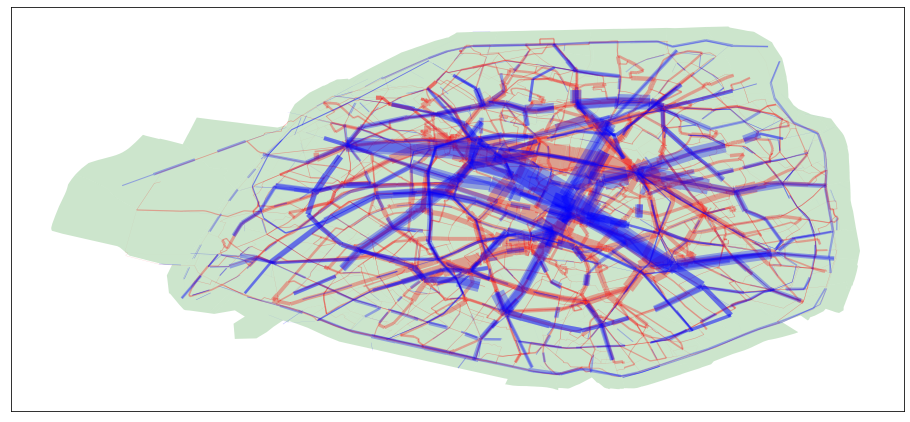

In [72]:
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / 35
sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))

In [82]:
# Summary of LoS table using a quetzal function
# All attributes are multiplied with path probabilities
od_sum = sm.summary_od(costs=['price', # EUR per person
                              'time', # seconds per ride
                              'in_vehicle_time', # seconds per ride
                              'length', # Meter distance
                              'ntransfers']) # per ride

In [83]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[(seg, 'length')] / 1000
    # Adjust units of other indicators
    od_sum[(seg, 'in_vehicle_time')] = od_sum[(seg, 'in_vehicle_time')] / 3600
    od_sum[(seg, 'time')] = od_sum[(seg, 'time')] / 3600
    od_sum[(seg, 'length')] = od_sum[(seg, 'length')] / 1000

In [84]:
od_sum.sample(3)

segment                    car_owner                                      \
sum                           volume     price      time in_vehicle_time   
origin  destination mode                                                   
zone_0  zone_104    rail    0.000260  0.001568  0.000274        0.000120   
zone_90 zone_62     bus     0.145144  0.008630  0.000948        0.000518   
zone_99 zone_107    subway  0.688955  0.066211  0.008461        0.003531   

segment                                         pt_captive            \
sum                           length ntransfers     volume     price   
origin  destination mode                                               
zone_0  zone_104    rail    0.004269   0.000940   0.009269  0.035490   
zone_90 zone_62     bus     0.017442   0.000000   5.177277  0.224261   
zone_99 zone_107    subway  0.142135   0.035313  18.960198  1.339893   

segment                                               ...             \
sum                             time in_vehicle_time  ... ntransfers   
origin  destination mode                              ...              
zone_0  zone_104    rail    0.006207        0.002714  ...   0.021269   
zone_90 zone_62     bus     0.024630        0.013456  ...   0.000000   
zone_99 zone_107    subway  0.171228        0.071461  ...   0.714610   

segment                          root                                      \
sum                            volume     price      time in_vehicle_time   
origin  destination mode                                                    
zone_0  zone_104    rail     0.009529  0.034564  0.006045        0.002643   
zone_90 zone_62     bus      5.322422  0.218380  0.023985        0.013103   
zone_99 zone_107    subway  19.649154  1.295234  0.165521        0.069079   

segment                                         car_owner pt_captive  \
sum                           length ntransfers       pkm        pkm   
origin  destination mode                                               
zone_0  zone_104    rail    0.094102   0.020714  0.000001   0.000896   
zone_90 zone_62     bus     0.441384   0.000000  0.002532   2.346701   
zone_99 zone_107    subway  2.780467   0.690792  0.097925  54.535897   

segment                          root  
sum                               pkm  
origin  destination mode               
zone_0  zone_104    rail     0.000897  
zone_90 zone_62     bus      2.349232  
zone_99 zone_107    subway  54.633822  

[3 rows x 21 columns]

array([<AxesSubplot:ylabel='car_owner'>,
       <AxesSubplot:ylabel='pt_captive'>], dtype=object)

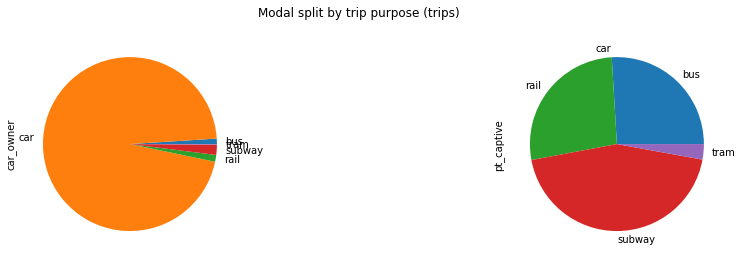

In [85]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')

array([<AxesSubplot:ylabel='car_owner'>,
       <AxesSubplot:ylabel='pt_captive'>], dtype=object)

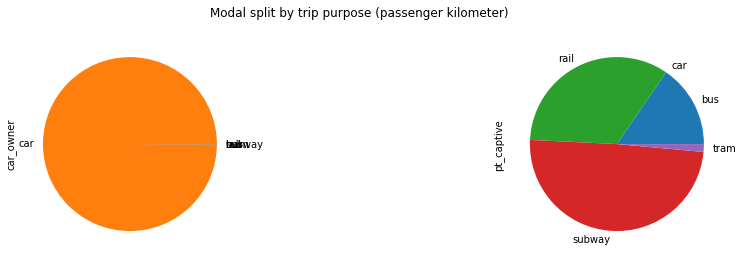

In [86]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

## Save model

In [93]:
# Save the od_sum as Excel
with pd.ExcelWriter('../../outputs/od_summary.xlsx') as writer:  
    od_sum.to_excel(writer, sheet_name='od_sum')

In [90]:
# make sure that all tables have unique indicies before saving
sm.probabilities.reset_index(inplace=True, drop=True)
sm.utilities.reset_index(inplace=True, drop=True)

In [91]:
sm.to_json(model_path + 'four_steps')



to_hdf(overwriting):   0%|                                                                      | 0/45 [00:00<?, ?it/s]

to_hdf(overwriting):  18%|███████████                                                   | 8/45 [00:01<00:06,  6.05it/s]

to_hdf(overwriting):  20%|████████████▍                                                 | 9/45 [00:02<00:18,  1.90it/s]

to_hdf(overwriting):  22%|█████████████▌                                               | 10/45 [00:07<01:08,  1.95s/it]

to_hdf(overwriting):  24%|██████████████▉                                              | 11/45 [00:08<00:49,  1.45s/it]

to_hdf(overwriting):  33%|████████████████████▎                                        | 15/45 [00:08<00:31,  1.04s/it]

to_hdf(overwriting):  36%|█████████████████████▋                                       | 16/45 [00:09<00:26,  1.07it/s]

to_hdf(overwriting):  38%|███████████████████████                                      | 17/45 [00:09<00:20,  1.35it/s]

to_hdf(overwriting):  40%|████

could not save geometry from table fare_rules
could not save geometry from table fare_attributes




to_hdf(overwriting):  73%|████████████████████████████████████████████▋                | 33/45 [00:12<00:02,  4.11it/s]

to_hdf(overwriting):  78%|███████████████████████████████████████████████▍             | 35/45 [00:14<00:05,  1.89it/s]

to_hdf(overwriting):  87%|████████████████████████████████████████████████████▊        | 39/45 [00:15<00:02,  2.63it/s]

to_hdf(overwriting):  91%|███████████████████████████████████████████████████████▌     | 41/45 [00:18<00:02,  1.37it/s]

to_hdf(overwriting):  93%|████████████████████████████████████████████████████████▉    | 42/45 [00:18<00:01,  1.85it/s]

to_hdf(overwriting):  98%|███████████████████████████████████████████████████████████▋ | 44/45 [00:18<00:00,  2.41it/s]

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 45/45 [00:18<00:00,  2.41it/s]

could not save attribute: parameters
